# Centralized Model Competition

Submission by: Nithesh Chandher Karthikeyan 

# Description

For the purpose of working towards better models, we select some pollutants which we will predict. We selected 4 pollutants (PM2.5, PM10, NOX as NO2, NO2) that appear in 4 measurement stations (8779, 8780, 8781, 18644).

You are requested to predict the concentration levels of the above-mentioned pollutants over the coming 24 hours for the 5 stations in Stockholm. You can use any features and pre-process techniques, but your model should perform a complete time series prediction for a whole day.

An evaluation system will evaluate your predictions every day and publish the ranking in a [Leader Board](http://user.it.uu.se/~sheli564/courses/projectdv20/leaderboard/)

In [1]:
import pandas as pd
import tensorflow as tf
import missingno as msno
import re
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
def create_df(PATH):
    # Loading the data
    df = pd.read_csv(PATH,sep=';',skiprows=12)
    df = df.drop(columns=['Slut'])
    column_indices = {i: name for i, name in enumerate(df.columns)}
    # Renaming column names
    for i in range(0,len(column_indices)):
        column = column_indices[i]
        if column.startswith('Black Carbon'):
            df.rename(columns = lambda x: re.sub('Black Carbon.*','Black Carbon',x), inplace = True)
        if column.startswith('CO'):
            df.rename(columns = lambda x: re.sub('CO.*','CO',x), inplace = True)
        if column.startswith('O3'):
            df.rename(columns = lambda x: re.sub('O3.*','O3',x), inplace = True)
        if column.startswith('NO2'):
            df.rename(columns = lambda x: re.sub('NO2.*','NO2',x), inplace = True)
        if column.startswith('NOX as NO2'):
            df.rename(columns = lambda x: re.sub('NOX as NO2.*','NOX as NO2',x), inplace = True)
        if column.startswith('PM10'):
            df.rename(columns = lambda x: re.sub('PM10.*','PM10',x), inplace = True)
        if column.startswith('PM2.5'):
            df.rename(columns = lambda x: re.sub('PM2.5.*','PM2.5',x), inplace = True)
    
    df = df.set_index('Start')
    df1 = pd.DataFrame()
    # Adding Air Pressure from Stockholm Station
    pressure = pd.read_csv('stockholm-airpressure.csv',sep=';',skiprows= 8)
    pressure = pressure.drop(columns=['Tidsutsnitt:','Unnamed: 4','Kvalitet'])
    pressure.rename(columns = lambda x: re.sub('Lufttryck.*','Air Pressure',x), inplace = True)
    pressure.rename(columns = lambda x: re.sub('Tid.*','Time',x), inplace = True) 
    pressure.rename(columns = lambda x: re.sub('Datum.*','Date',x), inplace = True) 
    pressure['Start']= pd.to_datetime(pressure['Date'] + ' ' + pressure['Time'])
    pressure = pressure.drop(columns=['Date','Time'])
    pressure = pressure[(pressure['Start']>= "2015-01-01 00:00:00")]
    pressure = pressure[(pressure['Start']<="2019-12-31 23:00:00")]
    pressure = pressure.set_index('Start')
    df1 = df1.merge(pressure, left_index=True, right_index=True ,how='outer')
    
    # Adding Air Temperature from Stockholm Station
    temp = pd.read_csv('stockholm-airtemp.csv',sep=';',skiprows= 8)
    temp = temp.drop(columns=['Tidsutsnitt:','Unnamed: 4','Kvalitet']) 
    temp.rename(columns = lambda x: re.sub('Lufttemperatur.*','Air Temperature',x), inplace = True)
    temp.rename(columns = lambda x: re.sub('Tid.*','Time',x), inplace = True) 
    temp.rename(columns = lambda x: re.sub('Datum.*','Date',x), inplace = True) 
    temp['Start']= pd.to_datetime(temp['Date'] + ' ' + temp['Time'])
    temp = temp.drop(columns=['Date','Time'])
    temp = temp[(temp['Start']>="2015-01-01 00:00:00")]
    temp = temp[(temp['Start']<="2019-12-31 23:00:00")]
    temp = temp.set_index('Start')
    df1 = df1.merge(temp, left_index=True, right_index=True ,how='outer')
    
    # Adding Relative Humidity data from Stockholm Station
    humidity = pd.read_csv('stockholm-humidity.csv',sep=';',skiprows= 8)
    humidity = humidity.drop(columns=['Tidsutsnitt:','Unnamed: 4','Kvalitet']) 
    humidity.rename(columns = lambda x: re.sub('Relativ Luftfuktighet.*','Humidity',x), inplace = True)
    humidity.rename(columns = lambda x: re.sub('Tid.*','Time',x), inplace = True) 
    humidity.rename(columns = lambda x: re.sub('Datum.*','Date',x), inplace = True) 
    humidity['Start']= pd.to_datetime(humidity['Date'] + ' ' + humidity['Time'])
    humidity = humidity.drop(columns=['Date','Time'])
    humidity = humidity[(humidity['Start']>= "2015-01-01 00:00:00")]
    humidity = humidity[(humidity['Start']<="2019-12-31 23:00:00")]
    humidity = humidity.set_index('Start')
    df1 = df1.merge(humidity, left_index=True, right_index=True ,how='outer')
    cols = ['Air Pressure','Air Temperature','Humidity']
    df1.loc[:,cols] = df1.loc[:,cols].ffill()
    df1.loc[:,cols] = df1.loc[:,cols].bfill()
    df = df.merge(df1, left_index=True, right_index=True, how='outer')
    df.reset_index(drop=False, inplace= True)
    
    # Converting datatype of feature 'Start' to datetime
    df['Start'] = pd.to_datetime(df['Start'])
    df['Year'] = df['Start'].dt.year
    df['Month'] = df['Start'].dt.month
    df['Week'] = df['Start'].dt.week
    df['DayOfWeek'] = df['Start'].dt.day_name()
    df = pd.concat([df,pd.get_dummies(df['DayOfWeek'])],axis=1)
    weekend={'Sunday':1,'Monday':0,'Tuesday':0,'Wednesday':0,'Thursday':0,'Friday':0,'Saturday':1}
    weekday={'Sunday':0,'Monday':1,'Tuesday':1,'Wednesday':1,'Thursday':1,'Friday':1,'Saturday':0}
    season={1:'Winter', 2:'Winter', 3:'Spring', 4:'Spring', 5:'Spring', 6:'Summer', 7:'Summer', 8:'Summer', 9:'Fall', 10:'Fall', 11:'Fall', 12:'Winter'} 
    df['Weekend']= df['DayOfWeek'].map(weekend)
    df['Weekday']= df['DayOfWeek'].map(weekday)
    df['Season']= df['Month'].map(season)
    df = pd.concat([df,pd.get_dummies(df['Season'])],axis=1)
    df = df.drop(columns=['DayOfWeek','Year','Month','Week','Season','Air Temperature'])
    
    return df

# Read data for the model



In [3]:
PATH1 = 'shair-8779-1-6-3.csv'
PATH2 = 'shair-8780-1-6-3.csv'
PATH3 = 'shair-8781-1-6-1.csv'
PATH4 = 'shair-18644-1-6-3.csv'
station1 = create_df(PATH1)
station2 = create_df(PATH2)
station3 = create_df(PATH3)
station4 = create_df(PATH4)
smape_values = pd.DataFrame(columns=['Station','NO2','NOX as NO2','PM10','PM2.5','Average'])

c:\users\jad\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
c:\users\jad\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:74: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


# Data Preprocessing

In [4]:
# to print zero entries, negative entries and null entries
def missingstats():  
  print('Station 1 Missing Values Stats:')
  print('----------------------------------------------')
  print('\nNo of Zeros Entries:\n',(station1.select_dtypes(include=['float64']) == 0).astype(int).sum(axis=0))
  print('\nNo of Negative Entries:\n',(station1.select_dtypes(include=['float64']) < 0).astype(int).sum(axis=0))
  print('\nNo of Null Entries:\n',(station1.select_dtypes(include=['float64']).isnull()).astype(int).sum(axis=0))
  print('\n\n')

  print('Station 2 Missing Values Stats:')
  print('----------------------------------------------')
  print('\nNo of Zeros Entries:\n',(station2.select_dtypes(include=['float64']) == 0).astype(int).sum(axis=0))
  print('\nNo of Negative Entries:\n',(station2.select_dtypes(include=['float64']) < 0).astype(int).sum(axis=0))
  print('\nNo of Null Entries:\n',(station2.select_dtypes(include=['float64']).isnull()).astype(int).sum(axis=0))
  print('\n\n')

  print('Station 3 Missing Values Stats:')
  print('----------------------------------------------')
  print('\nNo of Zeros Entries:\n',(station3.select_dtypes(include=['float64']) == 0).astype(int).sum(axis=0))
  print('\nNo of Negative Entries:\n',(station3.select_dtypes(include=['float64']) < 0).astype(int).sum(axis=0))
  print('\nNo of Null Entries:\n',(station3.select_dtypes(include=['float64']).isnull()).astype(int).sum(axis=0))
  print('\n\n')

  print('Station 4 Missing Values Stats:')
  print('----------------------------------------------')
  print('\nNo of Zeros Entries:\n',(station4.select_dtypes(include=['float64']) == 0).astype(int).sum(axis=0))
  print('\nNo of Negative Entries:\n',(station4.select_dtypes(include=['float64']) < 0).astype(int).sum(axis=0))
  print('\nNo of Null Entries:\n',(station4.select_dtypes(include=['float64']).isnull()).astype(int).sum(axis=0))
  print('\n\n')
  return None


# Data Imputation
Replacing negative values with zero and Data Imputation using Interpolation

In [5]:
station1 = station1.set_index('Start')
station1[station1 < 0] = 0
station1.reset_index(drop=False, inplace= True)
station1 = station1.interpolate(method ='linear', limit_direction ='forward')

station2 = station2.set_index('Start')
station2[station2 < 0] = 0
station2.reset_index(drop=False, inplace= True)
station2 = station2.interpolate(method ='linear', limit_direction ='forward')

station3 = station3.set_index('Start')
station3[station3 < 0] = 0
station3.reset_index(drop=False, inplace= True)
station3 = station3.interpolate(method ='linear', limit_direction ='forward')

station4 = station4.set_index('Start')
station4[station4 < 0] = 0
station4.reset_index(drop=False, inplace= True)
station4 = station4.interpolate(method ='linear', limit_direction ='forward')
missingstats()


Station 1 Missing Values Stats:
----------------------------------------------

No of Zeros Entries:
 NO2                0
NOX as NO2         0
PM10             137
PM2.5           3100
Air Pressure       0
Humidity           0
dtype: int64

No of Negative Entries:
 NO2             0
NOX as NO2      0
PM10            0
PM2.5           0
Air Pressure    0
Humidity        0
dtype: int64

No of Null Entries:
 NO2             0
NOX as NO2      0
PM10            0
PM2.5           0
Air Pressure    0
Humidity        0
dtype: int64



Station 2 Missing Values Stats:
----------------------------------------------

No of Zeros Entries:
 NO2              0
NOX as NO2       0
PM10            82
PM2.5            0
Air Pressure     0
Humidity         0
dtype: int64

No of Negative Entries:
 NO2             0
NOX as NO2      0
PM10            0
PM2.5           0
Air Pressure    0
Humidity        0
dtype: int64

No of Null Entries:
 NO2             0
NOX as NO2      0
PM10            0
PM2.5         

# Train-Validation Split and Normalization 

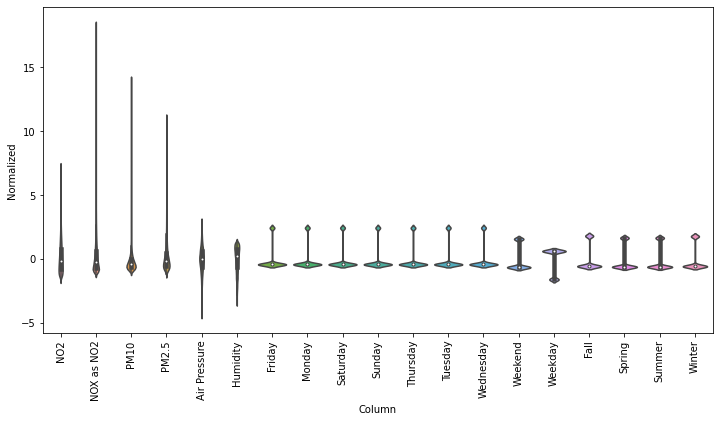

In [59]:
num_features = 4
n = 33293  # 80% of index

# Split for station 1
# index = station1[station1['Start']=='2019-09-30 00:00:00'].index.values.astype(int)[0]
# date_time = pd.to_datetime(station1.pop('Start'), format='%d.%m.%Y %H:%M:%S')
# column_indices = {name: i for i, name in enumerate(station1.columns)}
# train_df = station1.iloc[:n,:]
# val_df = station1.iloc[n:index,:]
# test_df = station1.iloc[index:,:]

#Split for station 2
# index = station2[station2['Start']=='2019-09-30 00:00:00'].index.values.astype(int)[0]
# date_time = pd.to_datetime(station2.pop('Start'), format='%d.%m.%Y %H:%M:%S')
# column_indices = {name: i for i, name in enumerate(station2.columns)}
# train_df = station2.iloc[:n,:]
# val_df = station2.iloc[n:index,:]
# test_df = station2.iloc[index:,:]

#Split for station 3
# index = station3[station3['Start']=='2019-09-30 00:00:00'].index.values.astype(int)[0]
# date_time = pd.to_datetime(station3.pop('Start'), format='%d.%m.%Y %H:%M:%S')
column_indices = {name: i for i, name in enumerate(station3.columns)}
train_df = station3.iloc[:n,:]
val_df = station3.iloc[n:index,:]
test_df = station3.iloc[index:,:]

# #Split for station 4
# index = station4[station4['Start']=='2019-09-30 00:00:00'].index.values.astype(int)[0]
# date_time = pd.to_datetime(station4.pop('Start'), format='%d.%m.%Y %H:%M:%S')
# column_indices = {name: i for i, name in enumerate(station4.columns)}
# train_df = station4.iloc[:n,:]
# val_df = station4.iloc[n:index,:]
# test_df = station4.iloc[index:,:]

train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
df_std = (station2 - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(station2.keys(), rotation=90)

## Data Windowing

In [60]:
#Indexes and Offset
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['PM10'])

#Split window
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

#Plot
def plot(self, model=None, plot_col='PM10', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index], #label_col_index
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

#Make Dataset
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

# Multi-steps model 

258/258 [==============================] - 0s 2ms/step - loss: 0.5858 - smape: 0.4785 - mean_absolute_error: 0.5150


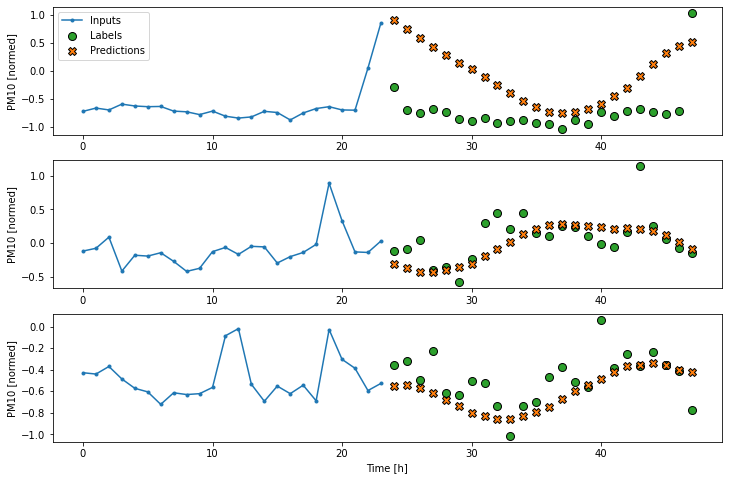

In [61]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS, 
                               shift=24,label_columns=['NO2','NOX as NO2','PM10','PM2.5'])

MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  def smape(y_true, y_pred):
        y_true = y_true * train_std[:num_features] + train_mean[:num_features]
        y_pred = y_pred * train_std[:num_features] + train_mean[:num_features]
        return tf.reduce_mean(2 * tf.abs(y_true - y_pred)
                              / (tf.abs(y_pred) + tf.abs(y_true)), axis=-1)
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[smape,tf.metrics.MeanAbsoluteError()])
  model.load_weights("ckpt")
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance = {}
multi_performance = {}
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [62]:
multi_lstm_model.save_weights('ckpt',save_format="tf")

## Predictions

In [53]:
predict = pd.DataFrame(columns=['NO2','NOX as NO2','PM10','PM2.5'])
idx= 0
for j in range(0,92):
  test = test_df.iloc[idx:idx+48,:]
  predict_window = WindowGenerator(input_width=24,
                               label_width=24, 
                               test_df = test,
                               shift=24,label_columns=['NO2','NOX as NO2','PM10','PM2.5'])
  values = multi_lstm_model.predict(predict_window.test)
  for i in range(0,24):
      dictionary = {'NO2':values[0][i][0], 'NOX as NO2':values[0][i][1],'PM10':values[0][i][2], 'PM2.5':values[0][i][3]}
      predict = predict.append(dictionary,ignore_index=True)
  idx=idx+24
predict= (predict*train_std)+train_mean
predict.drop(columns=['Air Pressure', 'Fall', 'Friday', 'Humidity', 'Monday',
        'Saturday', 'Spring', 'Summer', 'Sunday',
        'Thursday', 'Tuesday', 'Wednesday', 'Weekday', 'Weekend', 'Winter'])
predict['Start'] = pd.date_range(start='2019-10-01 00:00:00', periods=len(predict), freq='H')
predict = predict[['Start','NO2','NOX as NO2','PM10','PM2.5']]
predict.to_csv(r'18644.csv', index = False)
predict

,Start,NO2,NOX as NO2,PM10,PM2.5
0,2019-10-01 00:00:00,9.066192,21.572356,3.853692,0.730701
1,2019-10-01 01:00:00,8.764221,19.402070,4.723977,0.806097
2,2019-10-01 02:00:00,9.295992,18.742120,5.979500,0.877080
3,2019-10-01 03:00:00,11.312190,23.675070,7.484662,0.969555
4,2019-10-01 04:00:00,15.467671,34.570378,9.061594,1.102836
...,...,...,...,...,...
2203,2019-12-31 19:00:00,24.798946,42.797598,25.256112,3.822497
2204,2019-12-31 20:00:00,22.821032,35.996587,24.618432,3.758224
2205,2019-12-31 21:00:00,21.119008,30.733077,23.714170,3.720330
2206,2019-12-31 22:00:00,20.192078,28.643968,22.551903,3.692301


## Calculate SMAPE 

In [33]:
def smape(actual, predicted):
   dividend= np.abs(np.array(actual) - np.array(predicted))
   denominator = np.array(actual) + np.array(predicted)
   return 2 * np.mean(np.divide(dividend, denominator, out=np.zeros_like(dividend), where=denominator!=0, casting='unsafe'))

In [54]:
actual=station1.iloc[41616:,:]
actual.index = range(len(predict))
no2 = smape(actual['NO2'],predict['NO2'])
nox = smape(actual['NOX as NO2'],predict['NOX as NO2'])
pm2_5 = smape(actual['PM2.5'],predict['PM2.5'])
pm10 = smape(actual['PM10'], predict['PM10']) 
dict1 = {'Station':'18644','NO2':no2,'NOX as NO2':nox,'PM2.5':pm2_5,'PM10':pm10, 'Average':(no2+nox+pm2_5+pm10)/4 }
smape_values = smape_values.append(dict1,ignore_index=True)
smape_values

,Station,NO2,NOX as NO2,PM10,PM2.5,Average
0,8779,0.537029,0.724854,0.456019,0.524419,0.560580
1,8780,0.447764,0.484121,0.532798,0.421569,0.471563
2,8781,0.648590,0.060103,0.485788,0.488773,0.420814
3,18644,0.377894,0.458869,0.507069,0.544416,0.472062
4,18644,0.523763,0.760365,0.520029,0.548202,0.588090
5,18644,0.523763,0.760365,0.520029,0.548202,0.588090
6,18644,0.523763,0.760365,0.520029,0.548202,0.588090
7,18644,0.523763,0.760365,0.520029,0.548202,0.588090


In [43]:
smape_values['Average'].mean()

0.4812547561303572

In [45]:
!zip -r data.zip data

'zip' is not recognized as an internal or external command,
operable program or batch file.


In [55]:
smape_values = pd.DataFrame(columns=['Station','NO2','NOX as NO2','PM10','PM2.5','Average'])